In [1]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from joblib import Parallel, delayed
from numpy import ndarray, stack
from pandas import DataFrame, Series, option_context as pandas_option_context
from tqdm.auto import tqdm
from lazypredict.Supervised import LazyClassifier

from src.feature_extraction.eda import get_eda_features
from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data
from src.utils.misc import get_all_users
from src.utils.plots import (
    make_biometrics_plots_together_matplotlib,
    plot_binary_labels,
)
from src.utils.segmentation import segment
from src.utils.misc import get_labels_counts
from src.ml import resampling, local_resampling
from src.ml.cv import run_cross_validation_prediction

from src.ml.loso import run_same_side_classifications, run_different_classifications

# Intro

In this notebook, I analyse the artefact data. The idea is to identify which users might have more artefacts, and if they coincide with users having lower performance during the ML part.

# Data Preparation

The artefacts scripts have been moved inside the EDA filtering.

## Cognitive Load Info

In [2]:
path_to_experiment_info: str = "../data.nosync/usilaughs/all_experimento_info.csv"
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=1)

## Physiological Data

In [3]:
eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/67 [00:00<?, ?it/s]

565

In [4]:
users_in_left_side = set(eda_data['left'].keys())
users_in_right_side = set(eda_data['right'].keys())
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [5]:
segment_size_in_secs = 4
eda_sample_rate = 4

segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate
experiment_info_as_dict = experiment_info.to_dict()

In [6]:
(
    values_left,
    values_right,
    labels_left,
    labels_right,
    groups_left,
    groups_right,
    artefacts_left,
    artefacts_right,
) = segment(
    data=eda_data,
    experiment_info_as_dict=experiment_info_as_dict,
    segment_size_in_sampling_rate=segment_size_in_sampling_rate,
    segment_size_in_secs=segment_size_in_secs,
    data_sample_rate=eda_sample_rate,
    artefact=True,
)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

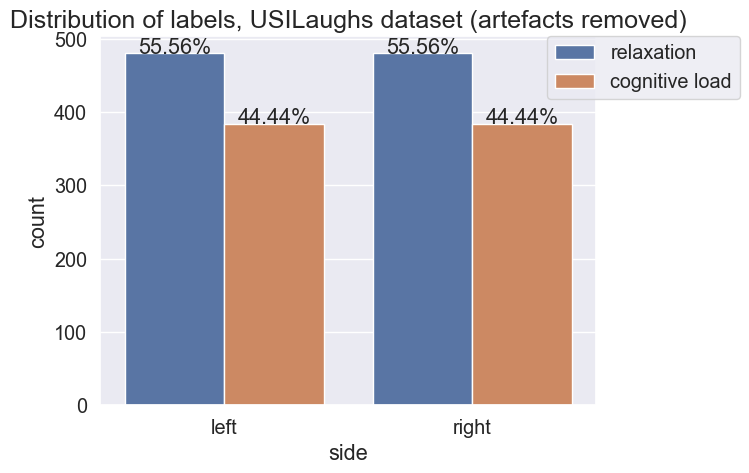

In [7]:
counts = get_labels_counts(labels_left, labels_right, ['relaxation', 'cognitive load'])
plot_binary_labels(
    counts=counts,
    title="Distribution of labels, USILaughs dataset (artefacts removed)",
    dataset_name="usilaughs_noartefacts",
    output_folder="../visualizations/"
)


The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Artefact Removal

In the previous notebook, the training of the model was done without regard for possible artefacts, present in the data. However, it is quite easy to have artefact in EDA data. As such, to methods shall be proposed here for artefact removal.

1. Using Shkurta's method (see https://github.com/shkurtagashi/EDArtifact)
2. Using a simple acc-based logic. The threshold will be decided upon visual inspection and looking at similar literature.

Both methods have been implemented inside the EDA filtering scripts. (only 1 at the moment, but second will follow soon)

## Feature Extraction

In [8]:
features_left = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_left)
)
features_right = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_right)
)

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)

artefacts_left: ndarray = stack(artefacts_left)
artefacts_right: ndarray = stack(artefacts_right)


/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which

In [9]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")
print(f"{artefacts_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)
artefacts_left.shape=(864,)


# Artefact Analysis

In [10]:
eda_features_names: list[str] = [
    "min_feat",
    "max_feat",
    "mean_feat",
    "std_feat",
    "dynamic_range_feat",
    "slope_feat",
    "absolute_slope_feat",
    "first_derivetive_mean_feat",
    "first_derivative_std_feat",
    "number_of_peaks_feat",
    "peaks_amplitude_feat",
]

In [25]:
data_left = DataFrame(features_left, columns=eda_features_names)
data_left['artefact'] = artefacts_left
data_left['artefact'] = data_left['artefact'].astype(bool)
data_left['user'] = groups_left
data_left['label'] = labels_left
data_left['label'] = data_left['label'].apply(lambda x: 'relaxation' if x == 0 else 'cognitive load')

data_right = DataFrame(features_right, columns=eda_features_names)
data_right['artefact'] = artefacts_right
data_right['artefact'] = data_right['artefact'].astype(bool)
data_right['user'] = groups_right
data_right['label'] = labels_right
data_right['label'] = data_right['label'].apply(lambda x: 'relaxation' if x == 0 else 'cognitive load')

In [27]:
def total_percentage_artefact(x: DataFrame) -> DataFrame:
    tot_artefacts = x['artefact'].sum()
    tot_elements = x.shape[0]
    return tot_artefacts / tot_elements

artefact_removed_percent_left = data_left.groupby('user').apply(total_percentage_artefact)
artefact_removed_percent_right = data_right.groupby('user').apply(total_percentage_artefact)

artefact_removed_percent = artefact_removed_percent_left.to_frame(name='artefact_removed_percent')
artefact_removed_percent['side'] = 'left'
artefact_removed_percent = artefact_removed_percent.append(artefact_removed_percent_right.to_frame(name='artefact_removed_percent').assign(side='right'))

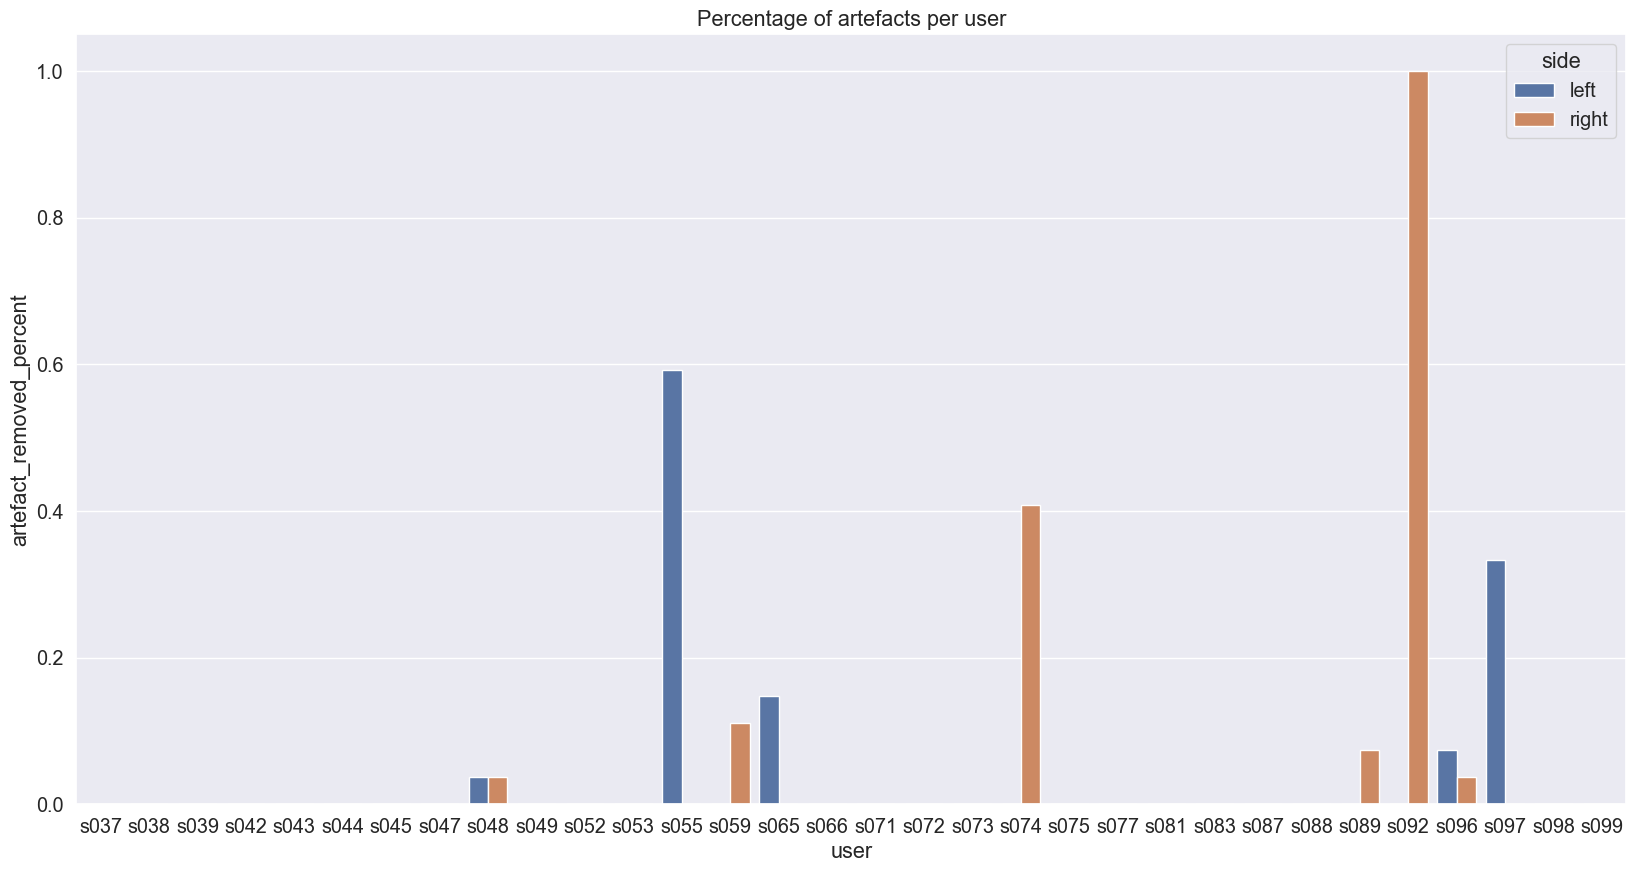

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

ax = sns.barplot(data=artefact_removed_percent, x=artefact_removed_percent.index, y='artefact_removed_percent', hue=artefact_removed_percent['side'])
plt.title("Percentage of artefacts per user")
# add minor gridlines for vertical axes
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=2, color='black', alpha=0.2)
plt.show()

### Artefact Removal

In [21]:
features_left = features_left[~artefacts_left.astype(bool)]
labels_left = labels_left[~artefacts_left.astype(bool)]
groups_left = groups_left[~artefacts_left.astype(bool)]

features_right = features_right[~artefacts_right.astype(bool)]
labels_right = labels_right[~artefacts_right.astype(bool)]
groups_right = groups_right[~artefacts_right.astype(bool)]

In [22]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")
print(f"{artefacts_left.shape=}")

features_left.shape=(832, 11)
labels_left.shape=(832,)
groups_left.shape=(832,)
artefacts_left.shape=(864,)


In [23]:
print('Percentage of data removed: %.2f%% ' % (abs(1 - artefacts_left.shape[0]/features_left.shape[0])*100))

Percentage of data removed: 3.85% 


In [ ]:
x = features_left
y = labels_left
groups = groups_left
data = DataFrame(x, index=groups)
data["label"] = y
len(data.loc['s055', 'label'].unique())

1